In [1]:
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Naturalness and typicality tasks

In [ ]:
def load_raw_data(fname: str, catch_criteria: dict = {}) -> pd.DataFrame:
  print(f"Loading raw data from \"{fname}\"")

  data = pd.read_csv(fname).reset_index()
  data = pd.melt(data, id_vars="index")

  data["variable"] = data.variable.str.split(" - ").map(lambda x: x[1] if len(x) > 1 else re.findall('"(.+)"', x[0])[0])

  data = data.rename(columns={"index": "participant", "variable": "sentence", "value": "rating"})

  data["verb"] = data.sentence.str.split().map(lambda x: x[2])

  print(f"Z-scoring data")

  data["zscore"] = data.groupby("participant", group_keys=False).rating.apply(lambda x: (x - x.mean())/x.std())

  data["is_bad"] = np.nan

  # filter bad participants based on catch criteria
  for sentence, criterion in catch_criteria.items():
    catch_zscore = data[data.sentence==sentence].zscore
    is_bad = catch_zscore.map(catch_criteria[sentence]).astype(int)
    data.loc[data.sentence==sentence,"is_bad"] = is_bad
    #data = pd.merge(data, data_sub, how="outer")

  data_catch = data[~data.is_bad.isnull()]

  participant_bad_count = data_catch.groupby(["participant"]).is_bad.sum().reset_index()
  bad_participants = participant_bad_count.query("is_bad > 1").participant.values

  print("Filtering the following participants:", list(bad_participants))

  data = data[data.is_bad.isnull()].drop(columns=["is_bad"])
  data = data[~data.participant.isin(bad_participants)]

  return data[["participant", "verb", "sentence", "rating", "zscore"]]

In [ ]:
nat_catch_criteria = {
  "The quickly the the it.": lambda x: x > 0., 
  "The florist arranged the flowers.": lambda x: x < 0., 
  "The duck ran the candle.": lambda x: x < 0.
}

nat = load_raw_data("naturalness_raw.csv", nat_catch_criteria)

nat

Loading raw data from "naturalness_raw.csv"
Z-scoring data
Filtering the following participants: []


,participant,verb,sentence,rating,zscore
0,0,arranged,The baby arranged the blocks.,100,0.884883
1,1,arranged,The baby arranged the blocks.,100,1.293480
2,2,arranged,The baby arranged the blocks.,100,0.975993
3,3,arranged,The baby arranged the blocks.,97,1.225976
4,4,arranged,The baby arranged the blocks.,100,1.380774
...,...,...,...,...,...
6815,50,threw,The jellyfish threw the while.,0,-1.442583
6816,51,threw,The jellyfish threw the while.,0,-0.977700
6817,52,threw,The jellyfish threw the while.,39,-0.452637
6818,53,threw,The jellyfish threw the while.,3,-1.163625


In [ ]:
typ_catch_criteria = {
  "The quickly the the it.": lambda x: x > 0., 
  "The florist arranged the flowers.": lambda x: x < 0., 
  "The duck ran the candle.": lambda x: x > 0.
}

typ = load_raw_data("typicality_raw.csv", typ_catch_criteria)

typ

Loading raw data from "typicality_raw.csv"
Z-scoring data
Filtering the following participants: []


,participant,verb,sentence,rating,zscore
0,0,arranged,The baby arranged the blocks.,99,1.561034
1,1,arranged,The baby arranged the blocks.,15,-0.249656
2,2,arranged,The baby arranged the blocks.,100,1.733132
3,3,arranged,The baby arranged the blocks.,37,0.188274
4,4,arranged,The baby arranged the blocks.,74,1.105352
...,...,...,...,...,...
6815,50,threw,The jellyfish threw the while.,0,-0.687019
6816,51,threw,The jellyfish threw the while.,0,-0.848392
6817,52,threw,The jellyfish threw the while.,5,-1.137923
6818,53,threw,The jellyfish threw the while.,18,-0.769674


In [ ]:
def compute_norming_rating(data):
  data_mean = data.groupby(["verb", "sentence"])[["zscore"]].mean().reset_index()

  return data_mean

In [ ]:
nat_mean = compute_norming_rating(nat)

nat_mean

,verb,sentence,zscore
0,arranged,The baby arranged the blocks.,1.081838
1,arranged,The baby arranged the something.,-0.228202
2,arranged,The time arranged the blocks.,0.149336
3,arranged,The time arranged the something.,-0.542995
4,bounced,The loudly bounced the ball.,-0.915410
...,...,...,...
119,threw,The jellyfish threw the while.,-1.038034
120,tore,The after tore the brick.,-1.025875
121,tore,The after tore the paper.,-0.963435
122,tore,The kid tore the brick.,0.719901


In [ ]:
typ_mean = compute_norming_rating(typ)

typ_mean

,verb,sentence,zscore
0,arranged,The baby arranged the blocks.,1.095987
1,arranged,The baby arranged the something.,0.070159
2,arranged,The time arranged the blocks.,-0.711305
3,arranged,The time arranged the something.,-0.663455
4,bounced,The loudly bounced the ball.,-0.717313
...,...,...,...
119,threw,The jellyfish threw the while.,-0.762181
120,tore,The after tore the brick.,-0.747499
121,tore,The after tore the paper.,-0.684086
122,tore,The kid tore the brick.,-0.551461


In [ ]:
nat_typ_mean = pd.merge(
  nat_mean.rename(columns={
      "zscore": "nat_zscore"
    }
  ),
  typ_mean.rename(columns={
      "zscore": "typ_zscore"
    }
  ),
)

nat_typ_mean

,verb,sentence,nat_zscore,typ_zscore
0,arranged,The baby arranged the blocks.,1.081838,1.095987
1,arranged,The baby arranged the something.,-0.228202,0.070159
2,arranged,The time arranged the blocks.,0.149336,-0.711305
3,arranged,The time arranged the something.,-0.542995,-0.663455
4,bounced,The loudly bounced the ball.,-0.915410,-0.717313
...,...,...,...,...
119,threw,The jellyfish threw the while.,-1.038034,-0.762181
120,tore,The after tore the brick.,-1.025875,-0.747499
121,tore,The after tore the paper.,-0.963435,-0.684086
122,tore,The kid tore the brick.,0.719901,-0.551461


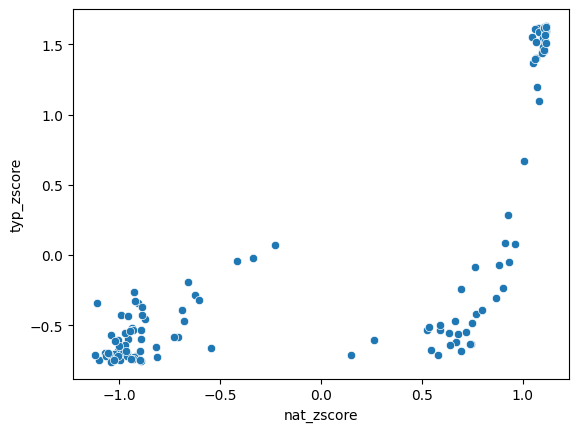

In [ ]:
_ = sns.scatterplot(nat_typ_mean, x="nat_zscore", y="typ_zscore")

In [32]:
def sample_by_extremeness(
    data, measure_column="zscore", verb_column="verb", n_sample=50, n_calibration=8, 
    mean_rejection_radius=0.05, verb_rejection_radius=0.5, verb_max_count=2
) -> pd.DataFrame:
  """Sample items based on distance to a target mean
  
  Samples are drawn starting from the items closest to the target mean and 
  moving outward in either direction. Samples are rejected in two circumstances:
  
  1. If the running mean is outside the mean_rejection_radius, samples that 
     would move it further outside the radius are rejected.
  2. If a verb is already in the sample, another sample containing that verb
     cannot be within the verb_rejection_radius.
  3. No more than verb_max_count instances of a verb can be in the sample. 

  Parameters
  ----------
  data
    The data to sample frm 
  measure_column
    The column containing the measure of interest (e.g. mean z-score)
  verb_column
    The column with the verb contained in the item
  n_sample
    The number of samples to draw
  n_calibration
    The number of items in the calibration block
  mean_rejection_radius
    The distance the running mean can get before the rejection mechanism 
    described above kicks in
  verb_rejection_radius
    The distance another item containing a verb that's already been seen has to
    be to retain that item
  verb_max_count
    The maximum number of times a verb can be used
  """
  gmm = GaussianMixture(2).fit(data[[measure_column]])
  center = gmm.means_.mean()

  print(f"The center is {center}.")

  data["extremeness"] = (data[measure_column] - center).abs()
  data_sorted = data.sort_values("extremeness").reset_index(drop=True)

  sample = [data_sorted.iloc[0]]

  running_sum = running_mean = data_sorted.iloc[0][measure_column]
  running_mean_trajectory = [[running_sum, running_sum]]

  last_score = {}
  verb_count = defaultdict(int, {data_sorted.iloc[0][verb_column]: 1})

  for idx, item in data_sorted.iloc[1:].iterrows():
    mean_outside_radius = np.abs(running_mean) > mean_rejection_radius
    signs_same = np.sign(running_sum) == np.sign(item[measure_column] - center)

    if mean_outside_radius and signs_same:
      continue

    verb_max_count_reached = verb_count[item[verb_column]] >= verb_max_count

    if verb_max_count_reached:
      continue

    if item[verb_column] in last_score:
      verb_in_radius = np.abs(last_score[item[verb_column]] - item[measure_column]) < verb_rejection_radius
      
      if verb_in_radius:
          continue

    sample.append(item)
    
    verb_count[item[verb_column]] += 1

    running_sum += (item[measure_column] - center)
    running_mean = running_sum/len(sample)
    last_score[item[verb_column]] = item[measure_column]

    if len(sample) == n_sample:
      break

  sample = pd.concat(sample, axis=1).T.iloc[:n_sample]

  if sample.shape[0] != n_sample:
    raise ValueError("Not enough items sampled. Loosen constraints.")

  sample["order"] = np.arange(sample.shape[0])

  # assign block
  sample["zscore_bins"] = pd.qcut(sample.zscore.astype(float), q=n_calibration)
  calibration_index = sample.groupby("zscore_bins").sample(1, random_state=40392).index
  sample["block"] = sample.index.map(lambda x: "calibration" if x in calibration_index else "experiment")

  sample = sample.sort_values(["block", "order"])

  return sample.drop(columns=["extremeness", "zscore_bins"])

In [ ]:
nat_sample = sample_by_extremeness(nat_mean, mean_rejection_radius=0.07)

nat_sample

The center is 0.000626514503271669.


,verb,sentence,zscore,order,block
1,arranged,The baby arranged the something.,-0.228202,1,calibration
15,split,The cow split the check.,0.641458,8,calibration
36,bounced,The player bounced the bottle.,0.866261,15,calibration
37,noticed,The stylist noticed the abruptly.,-0.869346,16,calibration
52,drove,The chauffeur drove the carefully.,-0.927087,26,calibration
87,shrunk,The washer shrunk the laundry.,1.048023,36,calibration
92,bumped,The car bumped the curb.,1.062882,41,calibration
95,clipped,The gardener clipped the was.,-1.069118,44,calibration
0,arranged,The time arranged the blocks.,0.149336,0,experiment
2,scratched,The dog scratched the war.,0.262877,2,experiment


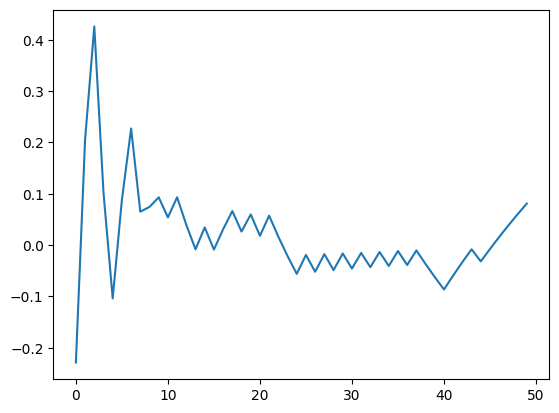

In [ ]:
nat_sample_calibration = nat_sample.query("block=='calibration'")

_ = plt.plot(np.arange(nat_sample.shape[0]), (nat_sample.zscore - 0.0006).expanding().mean())

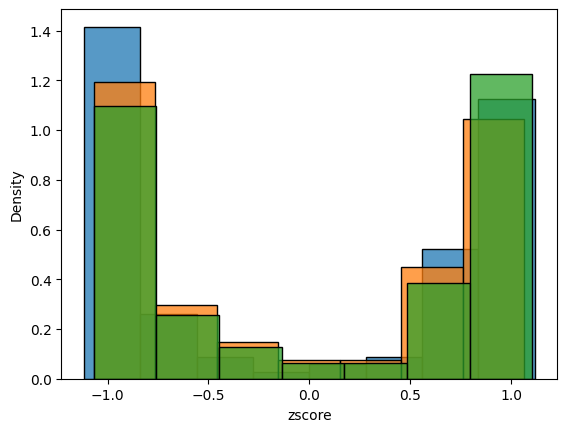

In [ ]:
_ = sns.histplot(nat_mean, x="zscore", stat="density")
_ = sns.histplot(nat_sample, x="zscore", stat="density")
_ = sns.histplot(nat_sample, x="zscore", stat="density")

In [ ]:
nat_sample.to_csv("naturalness_fillers.csv", index=False)

In [ ]:
typ_sample = sample_by_extremeness(typ_mean)

typ_sample

The center is 0.4852641173671224.


,verb,sentence,zscore,order,block
3,drove,The chef drove the limo.,0.080074,3,calibration
10,arranged,The baby arranged the blocks.,1.095987,4,calibration
30,bumped,The car bumped the curb.,1.404071,13,calibration
40,recognized,The flashlight recognized the mushroom.,-0.502027,20,calibration
54,mounted,The rider mounted the pen.,-0.55419,30,calibration
59,scratched,The dog scratched the itch.,1.544327,32,calibration
65,tore,The kid tore the paper.,1.566711,37,calibration
81,split,The cow split the check.,-0.63969,48,calibration
0,poisoned,The friend poisoned the king.,0.667192,0,experiment
1,discovered,The scientist discovered the wall.,0.286934,1,experiment


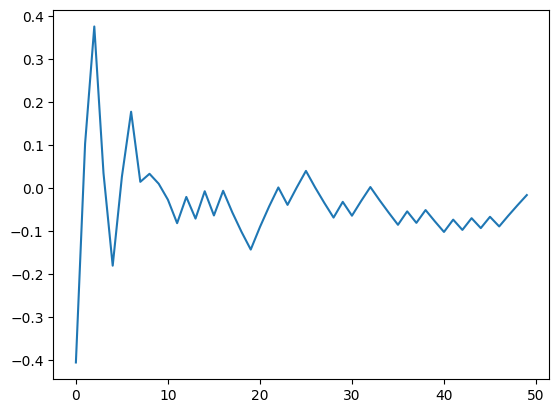

In [ ]:
typ_sample_calibration = typ_sample.query("block=='calibration'")

_ = plt.plot(np.arange(typ_sample.shape[0]), (typ_sample.zscore - 0.485).expanding().mean())

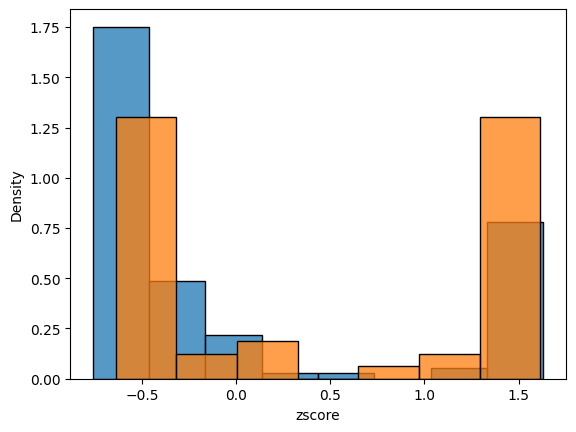

In [ ]:
_ = sns.histplot(typ_mean, x="zscore", stat="density")
_ = sns.histplot(typ_sample, x="zscore", stat="density")

In [ ]:
typ_sample.to_csv("typicality_fillers.csv", index=False)

In [ ]:
nat_typ_sample = pd.merge(
    nat_sample.drop(columns="block").rename(columns={"zscore": "nat_zscore", "extremeness": "nat_extremeness"}), 
    typ_sample.drop(columns="block").rename(columns={"zscore": "typ_zscore", "extremeness": "typ_extremeness"})
)

nat_typ_sample

,verb,sentence,nat_zscore,order,typ_zscore
0,clipped,The gardener clipped the hedge.,1.044281,34,1.553659


# Pair difference task

In [9]:
diff = pd.read_csv("longform_pairslider_fillers_051423-2.csv", index_col=0)

diff["zscore"] = diff.groupby("Rater ID", group_keys=False).Rating.apply(lambda x: (x - x.mean())/x.std())

diff.head()

,Rater ID,Pair_ID,Rating,Sentence1,Sentence2,Verb,zscore
0,1,arrange1,14.0,The baby arranged the blocks.,The florist arranged the flowers.,arrange,-0.801240
1,2,arrange1,58.0,The baby arranged the blocks.,The florist arranged the flowers.,arrange,-0.417791
2,3,arrange1,15.0,The baby arranged the blocks.,The florist arranged the flowers.,arrange,-0.551237
3,4,arrange1,0.0,The baby arranged the blocks.,The florist arranged the flowers.,arrange,-0.788284
4,5,arrange1,28.0,The baby arranged the blocks.,The florist arranged the flowers.,arrange,-0.955071


In [35]:
diff_mean = diff.groupby(["Pair_ID", "Verb", "Sentence1", "Sentence2"])[["zscore"]].mean().reset_index()

diff_mean

,Pair_ID,Verb,Sentence1,Sentence2,zscore
0,arrange1,arrange,The baby arranged the blocks.,The florist arranged the flowers.,-0.829784
1,arrange2,arrange,The baby arranged the blocks.,The secretary arranged the meeting.,0.636329
2,bounce1,bounce,The player bounced the ball.,The mom bounced the toddler.,0.136190
3,bounce2,bounce,The player bounced the ball.,The bank bounced the check.,1.138378
4,bump1,bump,The car bumped the curb.,The chair bumped the desk.,-0.889237
...,...,...,...,...,...
57,steal2,steal,The thief stole the painting.,The dancer stole the show.,1.035318
58,tear1,tear,The kid tore the paper.,The nail tore the fabric.,-0.578924
59,tear2,tear,The kid tore the paper.,The poem tore the heartstrings.,0.997968
60,throw1,throw,The athlete threw the javelin.,The referee threw the flag.,-0.528045


In [47]:
np.random.seed(43029)

diff_sample = sample_by_extremeness(diff_mean, verb_column="Verb", n_sample=30, n_calibration=6, verb_max_count=1)

diff_sample

The center is 0.09790206817051428.


,Pair_ID,Verb,Sentence1,Sentence2,zscore,order,block
6,find2,find,The bee found the flower.,The court found the liability.,0.427572,4,calibration
13,line1,line,The tailor lined the coat.,The insulation lined the attic.,-0.355583,8,calibration
19,discharge2,discharge,The hospital discharged the patient.,The bank discharged the loan.,0.69424,12,calibration
20,throw1,throw,The athlete threw the javelin.,The referee threw the flag.,-0.528045,13,calibration
45,butcher2,butcher,The farmer butchered the goat.,The consultant butchered the project.,1.015616,23,calibration
60,scratch1,scratch,The dog scratched the itch.,The patient scratched the rash.,-1.160648,29,calibration
0,permit2,permit,The college permitted the event.,The weather permitted the picnic.,0.070577,0,experiment
2,design2,design,The architect designed the building.,The strategist designed the message.,-0.023565,1,experiment
3,dismiss1,dismiss,The company dismissed the worker.,The teacher dismissed the class.,-0.039263,2,experiment
4,recognize2,recognize,The botanist recognized the mushroom.,The king recognized the bravery.,0.270833,3,experiment


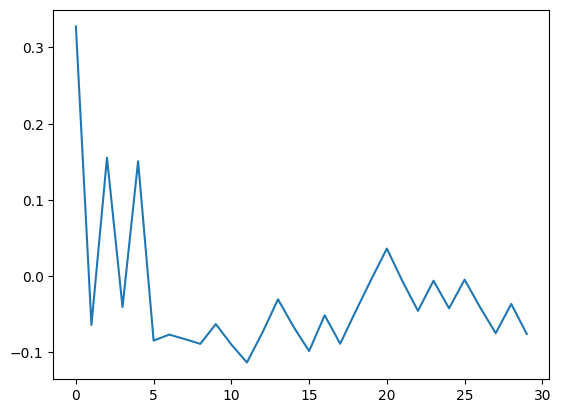

In [48]:
diff_sample_calibration = diff_sample.query("block=='calibration'")

_ = plt.plot(np.arange(diff_sample.shape[0]), (diff_sample.zscore - 0.1).expanding().mean())

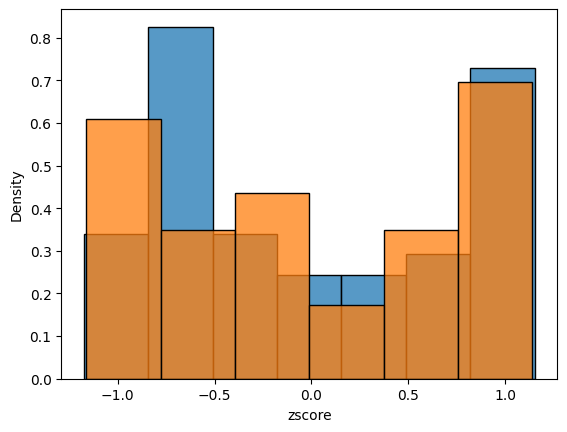

In [49]:
_ = sns.histplot(diff_mean, x="zscore", stat="density")
_ = sns.histplot(diff_sample, x="zscore", stat="density")

In [50]:
diff_sample.to_csv("difference_fillers.csv", index=False)